## Setup
Get additional files from repository if in colab.

In [1]:
def in_colab() -> bool:
    try:
        import google.colab  # noqa: F401
        return True
    except Exception:
        return False

if in_colab():
    !git clone https://github.com/MaxSpeer/applied-computer-vision-assignment2.git
    %cd applied-computer-vision-assignment2
    !pip install -r requirements.txt
    !pip install -e .
else:
    from pathlib import Path
    import sys
    project_root = Path("..").resolve()
    sys.path.append(str(project_root))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

False

In [5]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub

#fo.delete_dataset("multimodal-shapes-subset")
dataset = load_from_hub("maxspeer/assessment2_spheres_and_cube_2k_2",
                         name="multimodal-shapes-subset",
                         num_workers=1,
                         batch_size=500,
                        #max_samples=3000,
                           overwrite=True
                        )

/Users/maximilian/miniforge3/envs/compv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset
Importing samples...
 100% |███████████████| 6000/6000 [48.8ms elapsed, 0s remaining, 123.0K samples/s]  


In [6]:
from src.datasets import MultimodalDataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


IMG_SIZE = 64

img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),  # Scales data into [0,1] TODO correct non deprecated version
])

BATCH_SIZE = 32
train_dataset = MultimodalDataset(dataset,"train",img_transforms)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


val_dataset = MultimodalDataset(dataset,"val",img_transforms)
valid_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
from src.models import LateFusionModel
# Fusion models to compare
fusionModels = [
    ("late_maxPool2D", lambda: LateFusionModel(embedder="maxPool2D")),
    ("late_strided", lambda: LateFusionModel(embedder="strided")),
]


('late_strided', <function __main__.<lambda>()>)

In [8]:
from src.training import getWandbRun, train_model, get_outputs_fusion

epochs = 50

batch_size = 16
lr = 0.001

for mode, modelBlueprint in fusionModels:
    with getWandbRun(mode, "rgb/lidar", batch_size=batch_size, epochs=epochs, project_name="assessment2_notebook3") as run:
        model = modelBlueprint().to(device)

        print(f"Training fusion mode: {mode}")
        model_param_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Number of trainable parameters: {model_param_count}")
        run.config.update({"number_of_parameters": model_param_count})

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                        shuffle=True, drop_last=True)
        valid_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, drop_last=True)

        opt = Adam(model.parameters(), lr=lr)
        loss_func = nn.BCEWithLogitsLoss()
        train_loss, valid_loss = train_model(model=model,
                                            optimizer=opt,
                                            train_dataloader=train_dataloader,
                                            valid_dataloader=valid_dataloader,
                                            loss_func=loss_func,
                                            get_outputs=get_outputs_fusion,
                                            wandbrun=run,
                                            epochs=epochs)
        run.finish()

wandb: Currently logged in as: maximilian-speer (maximilian-speer-hasso-plattner-institut) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb.init fertig
Training fusion mode: late_maxPool2D
Number of trainable parameters: 13117093
Epoch 0: train loss = 0.6490
Epoch 0: valid loss = 0.5427 | F1=0.8079 P=0.6959 R=0.9630
Epoch 1: train loss = 0.4991
Epoch 1: valid loss = 0.4370 | F1=0.8279 P=0.7695 R=0.8960
Epoch 2: train loss = 0.4496
Epoch 2: valid loss = 0.4696 | F1=0.8243 P=0.7012 R=1.0000
Epoch 3: train loss = 0.3538
Epoch 3: valid loss = 0.3156 | F1=0.9145 P=0.8522 R=0.9866
Epoch 4: train loss = 0.3209
Epoch 4: valid loss = 0.2176 | F1=0.9288 P=0.8941 R=0.9663
Epoch 5: train loss = 0.2362
Epoch 5: valid loss = 0.1929 | F1=0.9474 P=0.9055 R=0.9933
Epoch 6: train loss = 0.1773
Epoch 6: valid loss = 0.2374 | F1=0.9365 P=0.9613 R=0.9130
Epoch 7: train loss = 0.1907
Epoch 7: valid loss = 0.1346 | F1=0.9656 P=0.9395 R=0.9933
Epoch 8: train loss = 0.1014
Epoch 8: valid loss = 0.1359 | F1=0.9553 P=0.9823 R=0.9298
Epoch 9: train loss = 0.1501
Epoch 9: valid loss = 0.1637 | F1=0.9631 P=0.9288 R=1.0000
Epoch 10: train loss = 0

learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▅▄▃▃▂▃▂▂▂▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▂▂▅▆▆▇▇▇▇██▇▇██████████████████████████
val_precision,▁▃▁▅▆▇▇█▇████▇██████████████████████████
val_recall,▆▁█▇▆▂██▆▇▆█▇▅▆███▇█████████████████████
valid_loss,█▇▅▃▃▂▂▃▂▂▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
learning_rate,0.001
train_loss,1e-05
val_precision,0.98013
val_recall,0.99329


wandb.init fertig
Training fusion mode: late_strided
Number of trainable parameters: 13117093
Epoch 0: train loss = 0.6541
Epoch 0: valid loss = 0.4894 | F1=0.8262 P=0.7394 R=0.9360
Epoch 1: train loss = 0.5067
Epoch 1: valid loss = 0.4653 | F1=0.7818 P=0.7595 R=0.8054
Epoch 2: train loss = 0.4594
Epoch 2: valid loss = 0.5125 | F1=0.7363 P=0.7790 R=0.6980
Epoch 3: train loss = 0.4250
Epoch 3: valid loss = 0.3885 | F1=0.8375 P=0.7813 R=0.9024
Epoch 4: train loss = 0.3902
Epoch 4: valid loss = 0.3827 | F1=0.8470 P=0.8117 R=0.8855
Epoch 5: train loss = 0.3441
Epoch 5: valid loss = 0.3032 | F1=0.8882 P=0.8266 R=0.9597
Epoch 6: train loss = 0.3239
Epoch 6: valid loss = 0.2906 | F1=0.8934 P=0.8281 R=0.9698
Epoch 7: train loss = 0.2805
Epoch 7: valid loss = 0.2693 | F1=0.8911 P=0.8616 R=0.9226
Epoch 8: train loss = 0.2883
Epoch 8: valid loss = 0.4068 | F1=0.8099 P=0.8604 R=0.7651
Epoch 9: train loss = 0.2595
Epoch 9: valid loss = 0.2390 | F1=0.9102 P=0.8400 R=0.9932
Epoch 10: train loss = 0.2

learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▆▆▅▄▄▄▄▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_f1,▄▂▁▄▄▆▃▆▆▆██▇██▆▇▆████▇█████████████████
val_precision,▁▂▂▃▄▅▅▄▄▅▇▆▅▇▆▇▆█▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_recall,▇▃▁▆▅▇▆██▇▇█▇▇█▄▇▅▇▇█▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇
valid_loss,▆▆▅▄▃▃▅▂▃▂▁▂█▁▂▃▂▁▂▂▃▁▃▂▂▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
learning_rate,0.001
train_loss,4e-05
val_precision,0.92971
val_recall,0.97651


| Metric | MaxPool2D Layer | Strided |
|---|---|---|
| Validation Loss (best) | 0.056679 | 0.1596 |
| F1 score  (best)| 0.98835 | 0.95935 |
| Parameters (count) | 13117093 | 13117093 |
| Training Time (seconds/epoch) * | 6.6s | 9.5s |

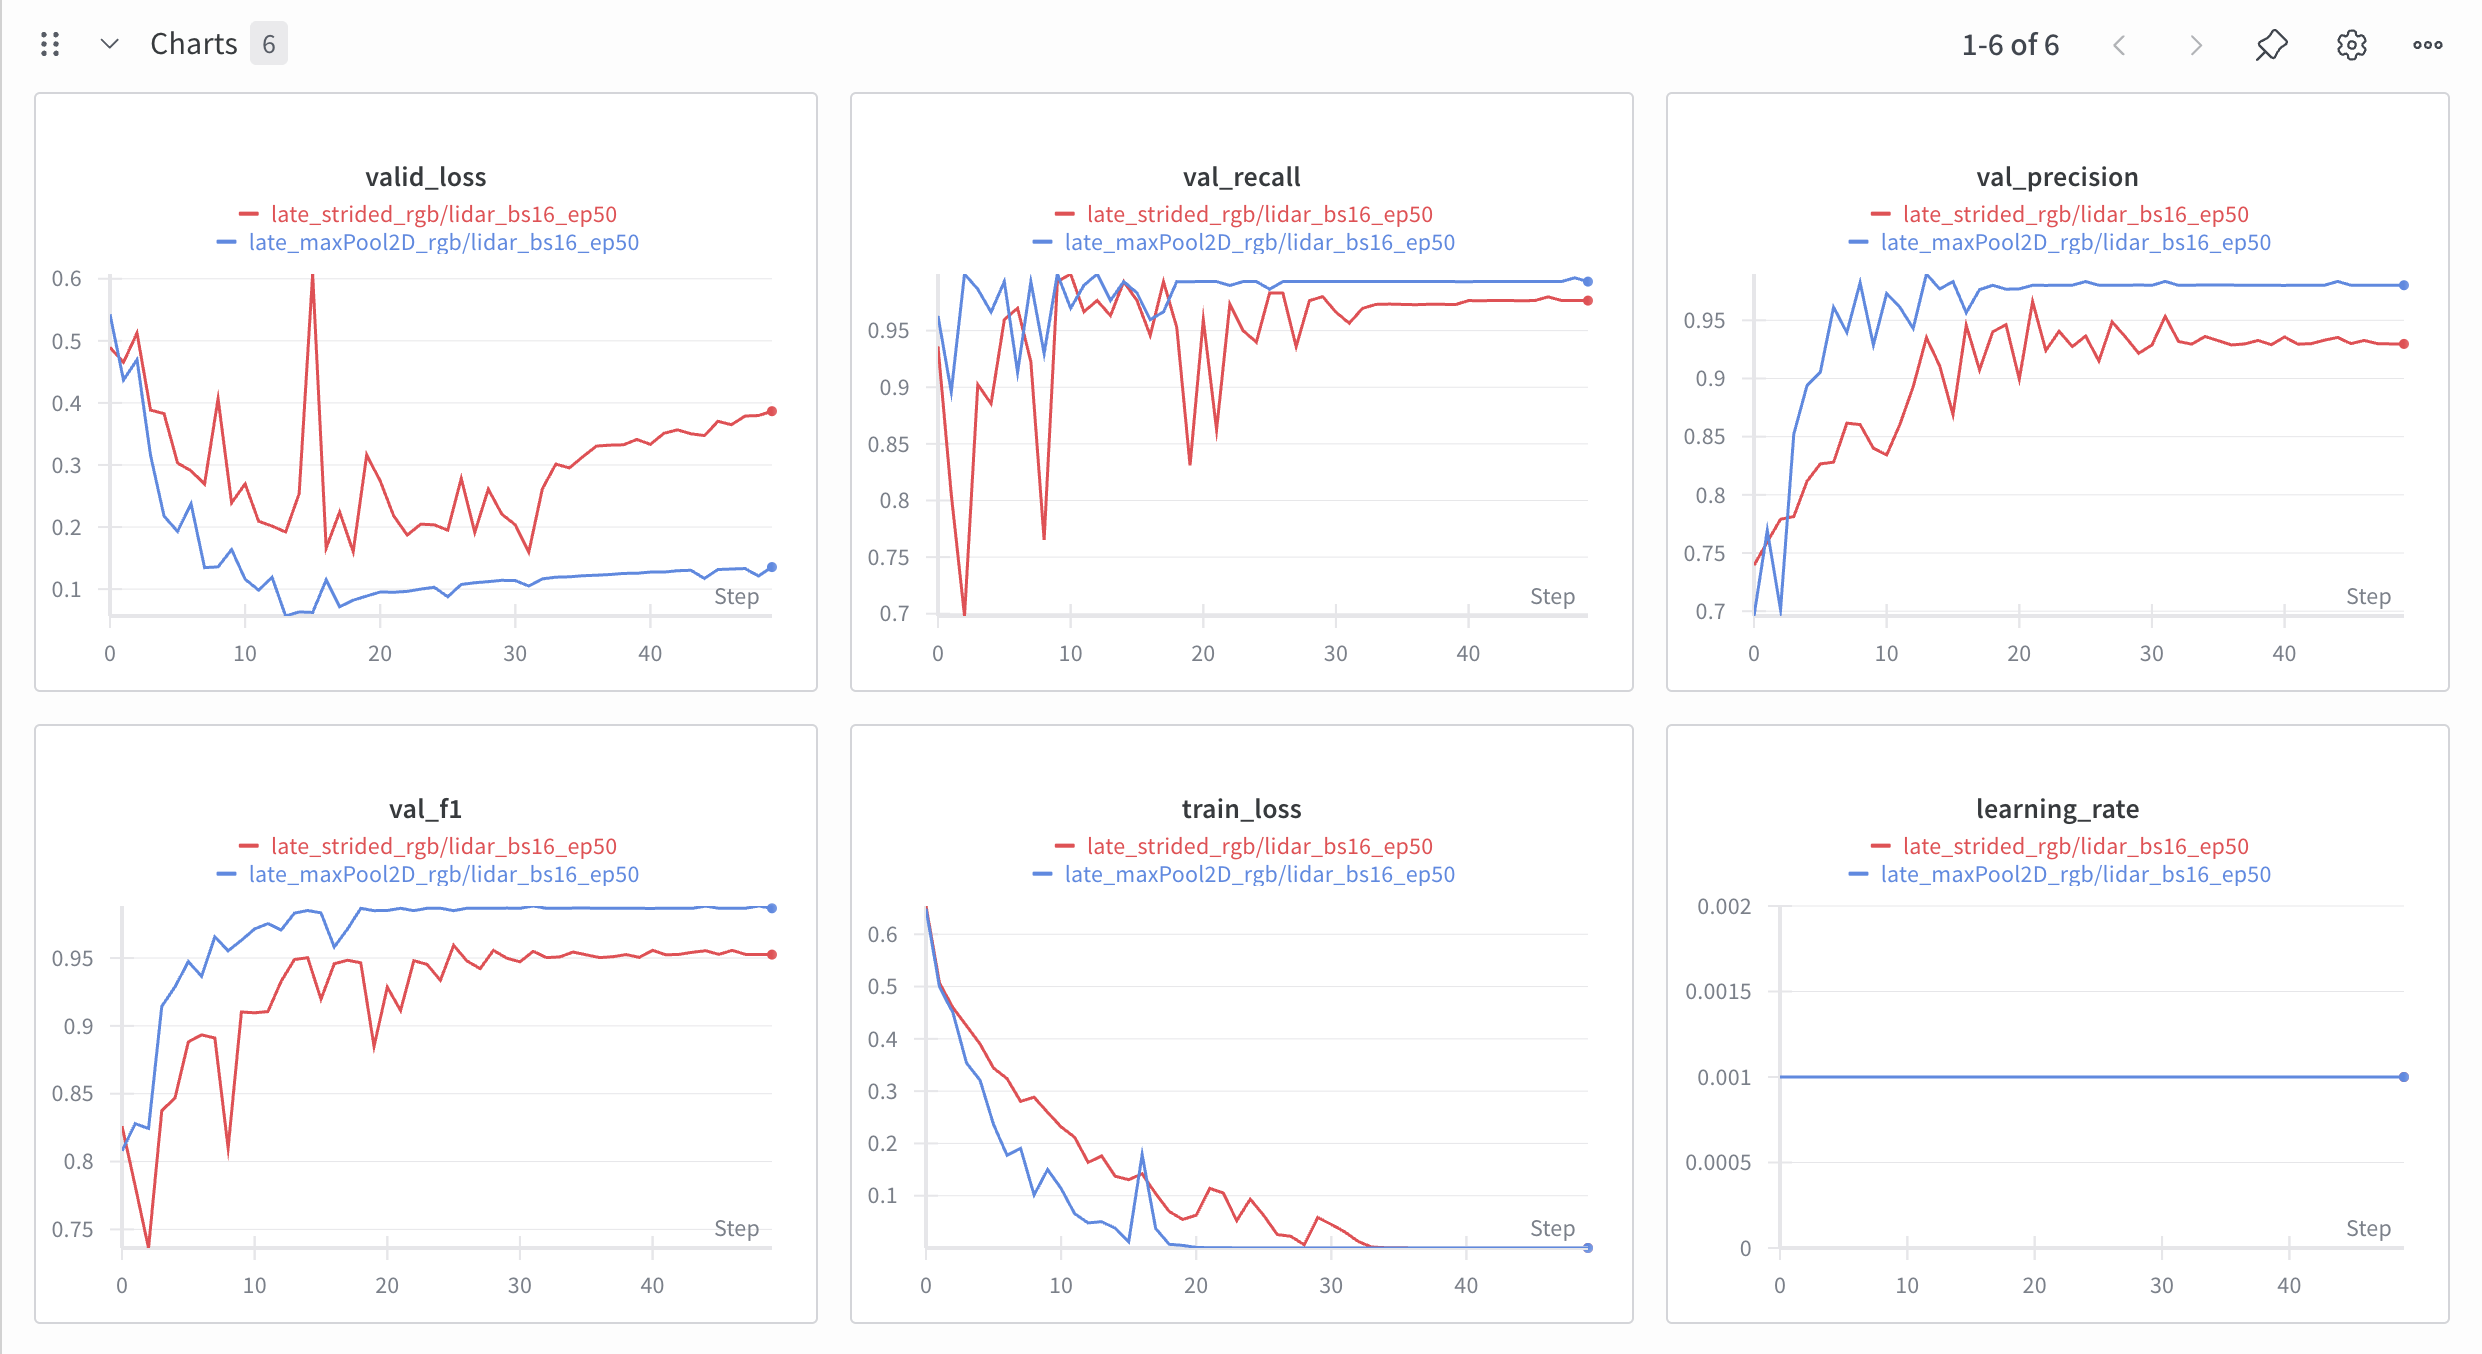

In the experiment we can clearly see a better performance for the Model using the MaxPool2D Layer for downsampling instead of relying on strided convolutions. Although having the same number of parameters, the best F1 score is higher (0.98) and the execution time per epoch is faster. 
This difference can be explained by looking at the downsampling steps in detail. The MaxPooling Layer downsamples the extracted feature maps after each convolution. This is done in a fixed way, keeping the strongest activation in the 2x2 window. Downsampling during the convolution step on the other hand uses learnable filters 